<a href="https://colab.research.google.com/github/Mostaq27/-Agroecological_Principles-_with-_AI-_for-_Crop-_Recommendation/blob/main/CROP_YIELD_PREDICTION_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#  CROP YIELD PREDICTION PIPELINE
#  Using "Crop recommendation dataset.csv"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load Data

df = pd.read_csv("Crop recommendation dataset.csv")
print(f"Dataset loaded: {df.shape}")
print(df.head())

Dataset loaded: (57000, 23)
  CROPS TYPE_OF_CROP           SOIL  SEASON SOWN HARVESTED WATER_SOURCE  \
0  rice      cereals  Alluvial soil  kharif  Jun       Sep    irrigated   
1  rice      cereals     Loamy soil  kharif  Jul       Oct      rainfed   
2  rice      cereals      Clay soil  kharif  Jun       Sep    irrigated   
3  rice      cereals  Alluvial soil  kharif  Jul       Oct      rainfed   
4  rice      cereals     Loamy soil  kharif  Jun       Sep    irrigated   

   SOIL_PH  SOIL_PH_HIGH  CROPDURATION  ...  WATERREQUIRED  WATERREQUIRED_MAX  \
0      7.6           8.0         116.9  ...         2462.3               2500   
1      6.2           8.0         117.9  ...         1237.5               2500   
2      6.7           8.0         117.7  ...         1075.1               2500   
3      6.1           8.0         149.8  ...         1549.9               2500   
4      8.0           8.0         131.7  ...         1306.4               2500   

   RELATIVE_HUMIDITY  RELATIVE_HUM

In [6]:
# 2. Feature Engineering
# -------------------------------
# Select numeric features
num_cols = ['SOIL_PH', 'SOIL_PH_HIGH',  # pH range
            'CROPDURATION', 'CROPDURATION_MAX',
            'TEMP', 'MAX_TEMP',
            'WATERREQUIRED', 'WATERREQUIRED_MAX',
            'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_MAX',
            'N', 'N_MAX', 'P', 'P_MAX', 'K', 'K_MAX']

# Target: Use CROPDURATION as yield proxy (or engineer one)
# Option 1: Use CROPDURATION directly
target = 'CROPDURATION'

# Option 2: Engineer Yield = f(nutrients, water, temp, duration)
# Example: Yield ~ N * P * K * WATERREQUIRED / CROPDURATION
df['YIELD_EST'] = (df['N'] * df['P'] * df['K'] * df['WATERREQUIRED']) / (df['CROPDURATION'] + 1)
# Use this as alternative target
# target = 'YIELD_EST'

X = df[num_cols].drop(columns=[target])  # Features
y = df[target]

print(f"\nTarget: {target}")
print(f"Features: {list(X.columns)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Target: CROPDURATION
Features: ['SOIL_PH', 'SOIL_PH_HIGH', 'CROPDURATION_MAX', 'TEMP', 'MAX_TEMP', 'WATERREQUIRED', 'WATERREQUIRED_MAX', 'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_MAX', 'N', 'N_MAX', 'P', 'P_MAX', 'K', 'K_MAX']
X shape: (57000, 15), y shape: (57000,)


In [7]:
# 3. Encode Categorical (if needed later)

le_crop = LabelEncoder()
df['CROP_ENCODED'] = le_crop.fit_transform(df['CROPS'])

# Add encoded crop type as feature (optional)
X['CROP_ENCODED'] = df['CROP_ENCODED']

In [8]:
# 4. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['CROP_ENCODED']
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")


Train: (45600, 16), Test: (11400, 16)


In [9]:
# 5. Scale Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# 6. Model Training & Evaluation

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = []

print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)

for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3),
        'R²': round(r2, 3)
    })

    print(f"{name:20} | MAE: {mae:6.3f} | RMSE: {rmse:6.3f} | R²: {r2:6.3f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n", results_df)


MODEL PERFORMANCE
Linear Regression    | MAE:  7.239 | RMSE: 10.623 | R²:  0.960
Random Forest        | MAE:  4.309 | RMSE:  7.471 | R²:  0.980
Gradient Boosting    | MAE:  4.367 | RMSE:  7.344 | R²:  0.981

                Model    MAE    RMSE     R²
0  Linear Regression  7.239  10.623  0.960
1      Random Forest  4.309   7.471  0.980
2  Gradient Boosting  4.367   7.344  0.981


In [11]:
# 7. Best Model: Random Forest (usually best)

best_model = RandomForestRegressor(n_estimators=300, random_state=42)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

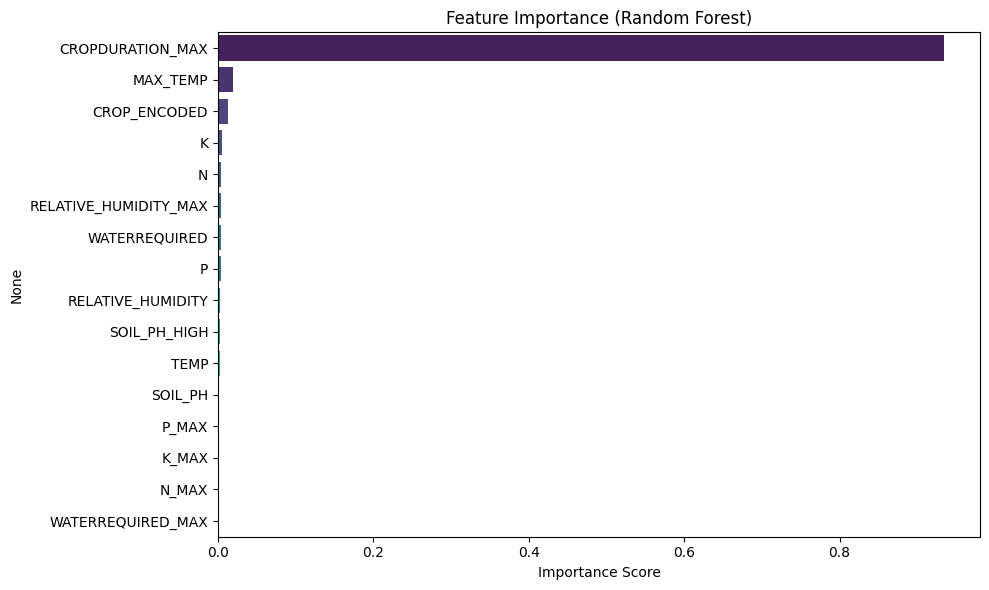

In [12]:
# 8. Feature Importance

importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

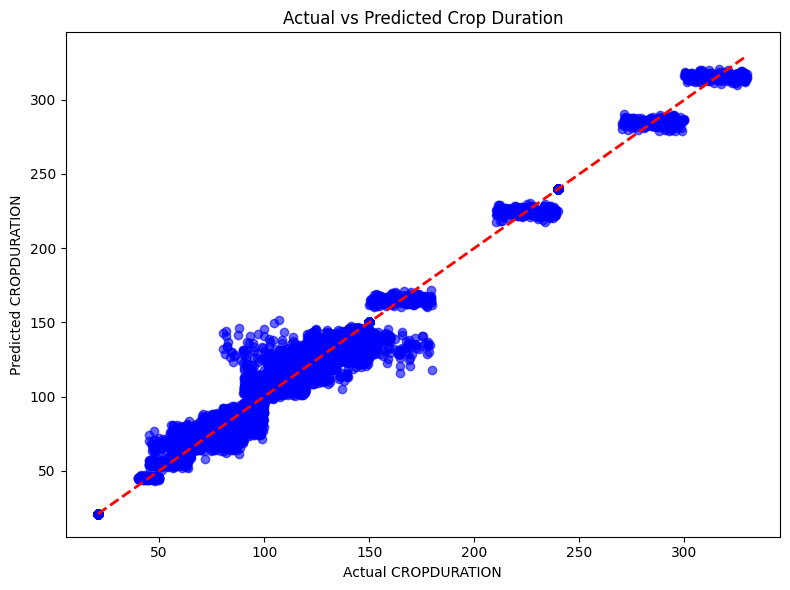

In [13]:
# 9. Prediction vs Actual Plot

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel(f"Actual {target}")
plt.ylabel(f"Predicted {target}")
plt.title("Actual vs Predicted Crop Duration")
plt.tight_layout()
plt.show()

In [14]:
# 10. Save Model & Scaler (Optional)

import joblib
joblib.dump(best_model, "crop_yield_predictor.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le_crop, "label_encoder_crop.pkl")
print("\nModel, scaler, and encoder saved!")


Model, scaler, and encoder saved!


In [16]:
# 11. Predict on New Data (Example)

def predict_yield(new_data):
    """
    new_data: dict with same features as X
    """
    new_df = pd.DataFrame([new_data])
    new_df['CROP_ENCODED'] = le_crop.transform([new_data['CROPS']])[0]
    new_df = new_df[X.columns]
    scaled = scaler.transform(new_df)
    if 'Linear' in str(best_model):
        pred = best_model.predict(scaled)[0]
    else:
        pred = best_model.predict(new_df)[0]
    return pred

# Example
sample = {
    'SOIL_PH': 6.5, 'SOIL_PH_HIGH': 8.0,
    'CROPDURATION_MAX': 150, 'TEMP': 28.0, 'MAX_TEMP': 40,
    'WATERREQUIRED': 1500, 'WATERREQUIRED_MAX': 2500,
    'RELATIVE_HUMIDITY': 70, 'RELATIVE_HUMIDITY_MAX': 80,
    'N': 80, 'N_MAX': 100, 'P': 50, 'P_MAX': 60,
    'K': 50, 'K_MAX': 60, 'CROPS': 'rice'
}

pred_duration = predict_yield(sample)
print(f"\nPredicted Crop Duration: {pred_duration:.2f} days")


Predicted Crop Duration: 131.06 days
